In [40]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

,cluster,function,result,time,index,submit-id
0,dask-ws-rsds-worker-1n-24p-1t,merge-10000,42,3.113123,0,9833175.isrv5
1,dask-ws-rsds-worker-1n-24p-1t,merge-10000,42,3.103525,1,9833175.isrv5
2,dask-ws-rsds-worker-1n-24p-1t,merge-10000,42,3.073087,2,9833175.isrv5
3,dask-ws-rsds-worker-1n-24p-1t,merge-10000,42,3.137830,3,9833175.isrv5
4,dask-ws-rsds-worker-1n-24p-1t,merge-10000,42,3.064583,4,9833175.isrv5
...,...,...,...,...,...,...
195,rsds-ws-dask-7n-24p-1t,merge-30000,4499850000,6.314328,0,9833224.isrv5
196,rsds-ws-dask-7n-24p-1t,merge-30000,4499850000,6.220164,1,9833224.isrv5
197,rsds-ws-dask-7n-24p-1t,merge-30000,4499850000,6.299554,2,9833224.isrv5
198,rsds-ws-dask-7n-24p-1t,merge-30000,4499850000,6.190304,3,9833224.isrv5


In [3]:
def read_data(filename):
    import re
    renames = {
            re.compile(r"^pandas.*"): lambda s: s[7:],
            re.compile(r"^wordbatch_.*"): lambda s: s[10:].replace("wordbatch.csv-", "")
    }

    def function_rename(name):
        for r, t in renames.items():
            if r.match(name):
                return t(name)
        return name

    with open(filename) as f:
        df = pd.read_json(f)
    df["function"] = df.function.apply(function_rename)

    def extract_nodes(data):
        name = data.cluster.split("-")
        return int(name[3][:-1])

    df["benchmark"] = df.function
    df["scheduler"] = df.cluster.apply(lambda x: x.split("-")[1])
    df["nodes"] = df.apply(extract_nodes, axis=1)
    df["workers"] = df["nodes"] * 24
    df["runtime"] = df.cluster.apply(lambda x: x.split("-")[0])
    df["worker"] = df.cluster.apply(lambda x: x.split("-")[2])

    def make_cname(row):
        name = "{}-{}-{}w".format(row.runtime, row.scheduler, row.workers)
        return name
    df["cname"] = df.apply(make_cname, axis=1)
    return df

df = read_data("result-a.json")
df2 = read_data("result-b.json")
df3 = read_data("result-c.json")


In [44]:
def read_old_data():
    import re
    renames = {
            re.compile(r"^pandas.*"): lambda s: s[7:],
            re.compile(r"^wordbatch_.*"): lambda s: s[10:].replace("wordbatch.csv-", "")
    }

    def function_rename(name):
        for r, t in renames.items():
            if r.match(name):
                return t(name)
        return name

    df = pd.read_json(open("../exp2/result.json"))
    df["function"] = df.function.apply(function_rename)
    #df["cluster"] = df.cluster.apply(cluster_rename)
    df.function.unique()

    def extract_nodes(data):
        name = data.cluster.split("-")
        return int(name[2][:-1])

    def make_cname(row):
        name = "{}-{}-{}w".format(row.runtime, row.scheduler, row.workers)
        return name

    df["benchmark"] = df["function"]
    df["scheduler"] = df.cluster.apply(lambda x: x.split("-")[1])
    df["nodes"] = df.apply(extract_nodes, axis=1)
    df["workers"] = df["nodes"] * 24
    df["runtime"] = df.cluster.apply(lambda x: x.split("-")[0])
    df["cname"] = df.apply(make_cname, axis=1)
    return df
exp2_df = read_old_data()

In [16]:
MERGE_SIZES = {
    "merge-{}".format(x): x + 1 for x in [10_000, 15_000, 20_000, 25_000, 30_000, 40_000, 50_000, 60_000, 70_000]
}

#SIZES = MERGE_SIZES.copy()
#SIZES["bag-50000-50"] = 0

MERGE_SIZES

{'merge-10000': 10001,
 'merge-15000': 15001,
 'merge-20000': 20001,
 'merge-25000': 25001,
 'merge-30000': 30001,
 'merge-40000': 40001,
 'merge-50000': 50001,
 'merge-60000': 60001,
 'merge-70000': 70001}

AttributeError: 'DataFrame' object has no attribute 'benchmarks'

   nodes scheduler     ttime
0      1    random  0.067082
1      1        ws  0.067832
2      7    random  0.070552
3      7        ws  0.073607
nan


/home/spirali/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


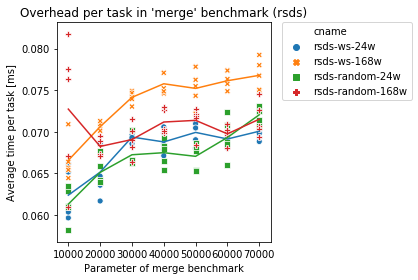

   nodes scheduler     ttime
0      1    random  0.299694
1      1        ws  0.328021
2      7    random  0.305922
3      7        ws  0.383738
nan


/home/spirali/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


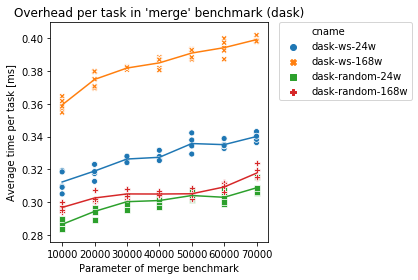

In [26]:
def tab(df, runtime):
    dg = pd.DataFrame(df[df.function.isin(list(MERGE_SIZES)) & (df.worker == "zw") & (df.runtime==runtime)])
    dg["n"] = dg.function.apply(lambda x: int(x.split("-")[1]))

    dg["ttime"] = dg.apply(lambda r: r.time / MERGE_SIZES[r.benchmark] * 1000, axis=1)
    #dg["key"] = dg.apply(lambda r: "{}-{}-{}w".format(r.runtime, r.scheduler, r.workers), axis=1)
    
    print(dg.groupby(["nodes", "scheduler"], as_index=False)["ttime"].mean())
    print(dg[dg["nodes"] == "ws"]["ttime"].mean())
    
    sns.lineplot(data=dg, x="n", y="ttime", hue="cname", ci=None, legend=False)
    g = sns.scatterplot(data=dg, x="n", y="ttime", hue="cname", style="cname")

    plt.title("Overhead per task in 'merge' benchmark ({})".format(runtime))
    plt.ylabel("Average time per task [ms]")
    plt.xlabel("Parameter of merge benchmark")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f"tt-merge-{runtime}.png")
    plt.show()
    
tab(df2, "rsds")
tab(df2, "dask")
#plt.legend(title='', loc='center right', labels=['Hell Yeh', 'Nah Bruh'])

#dg = dg.groupby(["n", "runtime", "scheduler", "workers"], as_index=False)["time"].mean()

#baseline = dg[(dg.runtime == "dask") & (dg.scheduler == "ws")].set_index(["n", "workers"])
#rsds = dg[(dg.runtime == "rsds") & (dg.scheduler == "ws")].set_index(["n", "workers"])

#(baseline["time"] / rsds["time"]).reset_index().plot(x="n", y="workers")

    nodes scheduler     ttime
0       1    random  0.302613
1       1        ws  0.331504
2       2    random  0.306368
3       2        ws  0.343980
4       3    random  0.305722
5       3        ws  0.349231
6       4    random  0.308925
7       4        ws  0.361090
8       5    random  0.307620
9       5        ws  0.370714
10      6    random  0.307150
11      6        ws  0.381815
12      7    random  0.307296
13      7        ws  0.388796
nan


/home/spirali/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


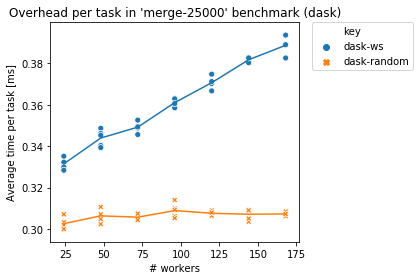

    nodes scheduler     ttime
0       1    random  0.069009
1       1        ws  0.069887
2       2    random  0.069714
3       2        ws  0.069437
4       3    random  0.071367
5       3        ws  0.069628
6       4    random  0.069535
7       4        ws  0.071132
8       5    random  0.070161
9       5        ws  0.071772
10      6    random  0.070172
11      6        ws  0.073489
12      7    random  0.070146
13      7        ws  0.075737
nan


/home/spirali/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


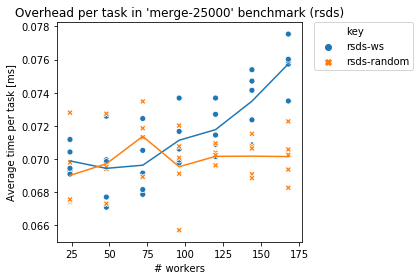

In [43]:
from sklearn.linear_model import LinearRegression
def tab2(runtime):
    df = df3
    dg = pd.DataFrame(df[df.function.isin(list(MERGE_SIZES)) & (df.worker == "zw") & (df.runtime==runtime)])
    dg["n"] = dg.function.apply(lambda x: int(x.split("-")[1]))

    dg["ttime"] = dg.apply(lambda r: r.time / SIZES[r.benchmark] * 1000, axis=1)
    dg["key"] = dg.apply(lambda r: "{}-{}".format(r.runtime, r.scheduler), axis=1)
    
    inp = dg["workers"].values.reshape(-1, 1)
    lg = LinearRegression()
    lg.fit(inp, dg["ttime"])
    pred = lg.predict(inp) 
    
    print(dg.groupby(["nodes", "scheduler"], as_index=False)["ttime"].mean())
    print(dg[dg["nodes"] == "ws"]["ttime"].mean())
    
    sns.lineplot(data=dg, x="workers", y="ttime", hue="key", ci=None, legend=False)
    g = sns.scatterplot(data=dg, x="workers", y="ttime", hue="key", style="key")

    #print("PRED", pred)
    #plt.plot(inp, pred, color='red')
    
    plt.title("Overhead per task in 'merge-25000' benchmark ({})".format(runtime))
    plt.ylabel("Average time per task [ms]")
    plt.xlabel("# workers")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f"tt-merge-25000-{runtime}.png")
    plt.show()    
    
tab2("dask")
tab2("rsds")

[1 7]
function
xarray-5              1.417296
xarray-25             1.429007
bag-50000-50          1.571210
groupby-1440-1s-1H    2.336349
groupby-1440-1s-8H    2.364820
numpy-50000-100       2.423092
join-1-1s-1T          3.062666
join-1-1s-1H          3.427242
join-1-2s-1H          3.436059
merge-30000           4.866939
merge-10000           5.030262
tree-15               5.831020
Name: time, dtype: float64


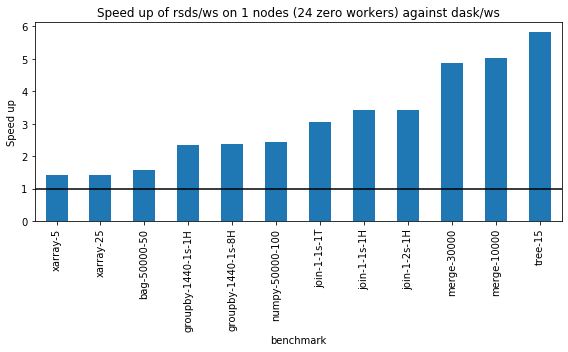

[1 7]
function
xarray-25             1.112312
join-1-2s-1H          1.144357
join-1-1s-1H          1.148559
xarray-5              1.417583
bag-50000-50          1.553129
groupby-1440-1s-8H    2.303016
groupby-1440-1s-1H    2.377201
numpy-50000-100       2.441080
join-1-1s-1T          2.895139
merge-10000           4.574627
merge-30000           5.135225
tree-15               5.543365
Name: time, dtype: float64


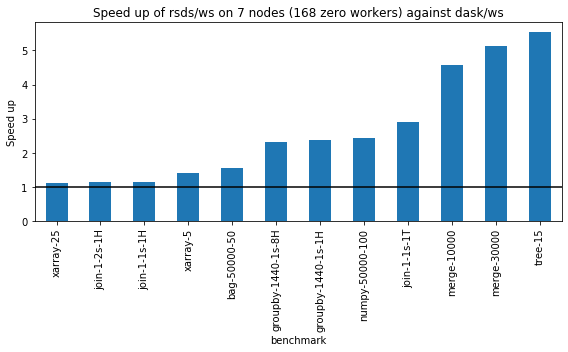

In [41]:
def get(df, runtime, scheduler, nodes):
    return df[(df.scheduler == scheduler) & (df.runtime == runtime) & (df.nodes == nodes) & (~df.benchmark.isin(["merge-15000", "merge-20000", "merge-25000"]))]

def comprel(df, runtime, scheduler, nodes):
    #baseline = get("rsds", "random", nodes).groupby("function")["time"].mean()
    baseline = get(df, "dask", "ws", nodes).groupby("function")["time"].mean()
    print(df.nodes.unique())
    vals = get(df, runtime, scheduler, nodes).groupby("function")["time"].mean()
    r = baseline / vals
    return r.sort_values()

confs = [
    ("rsds", "ws"),
]

for r, s in confs:
    for nodes in [1, 7]:
        plt.close()
        plt.figure(figsize=(8, 5))
        plt.title("Speed up of {}/{} on {} nodes ({} zero workers) against dask/ws".format(r, s, nodes, nodes * 24))
        
        #s1 = comprel(exp2_df, r, s, nodes)
        s2 = comprel(df, r, s, nodes)        
        
        print(s2)
        #new_df = pd.concat([s1, s2], axis=1).dropna()
        
        s2.plot.bar()
        
        plt.xlabel("benchmark")        
        plt.ylabel("Speed up")        
        plt.axhline(y=1.0, color='black', linestyle='-')
        #plt.autoscale()
        plt.tight_layout()
        plt.savefig("speedup-zw-{}-{}-{}.png".format(r, s, nodes), tight_layout=True)
        plt.show()

In [24]:
tab = """
bag-25000-10 & 236 & 415 & 292.583 & 1233.481 & 6 & B \\
bag-25000-100 & 21631 & 41430 & 3.220 & 13.905 & 8 & B \\
bag-25000-200 & 86116 & 165715 & 0.826 & 3.564 & 9 & B \\
bag-25000-50 & 5458 & 10357 & 12.622 & 54.917 & 7 & B \\
bag-50000-50 & 5458 & 10357 & 25.235 & 214.994 & 7 & B \\
merge-10000 & 10001 & 10000 & 0.027 & 0.006 & 1 & F \\
merge-15000 & 15001 & 15000 & 0.027 & 0.006 & 1 & F \\
merge-20000 & 20001 & 20000 & 0.027 & 0.006 & 1 & F \\
merge-25000 & 25001 & 25000 & 0.027 & 0.006 & 1 & F \\
merge-30000 & 30001 & 30000 & 0.027 & 0.006 & 1 & F \\
merge-50000 & 50001 & 50000 & 0.027 & 0.006 & 1 & F \\
merge\_slow-5000-0.1 & 5001 & 5000 & 0.023 & 100.432 & 1 & F \\
numpy-50000-10 & 209 & 228 & 70108.959 & 169.394 & 7 & A \\
numpy-50000-100 & 19334 & 21783 & 760.202 & 2.586 & 10 & A \\
numpy-50000-200 & 77067 & 86966 & 191.463 & 0.854 & 11 & A \\
numpy-50000-50 & 4892 & 5491 & 2999.201 & 8.329 & 9 & A \\
groupby-1440-1s-1H & 182682 & 251801 & 64.324 & 3.819 & 10 & D \\
groupby-1440-1s-8H & 22842 & 31481 & 503.409 & 7.731 & 9 & D \\
groupby-360-1s-1H & 45674 & 62953 & 64.319 & 3.811 & 9 & D \\
groupby-360-1s-8H & 5714 & 7873 & 503.178 & 7.998 & 8 & D \\
groupby-90-1s-1H & 11424 & 15743 & 64.293 & 3.903 & 8 & D \\
groupby-90-1s-8H & 1434 & 1973 & 501.119 & 7.673 & 7 & D \\
join-1-1s-1H & 673 & 1224 & 15.254 & 33.014 & 5 & D \\
join-1-1s-1T & 72001 & 125568 & 3.664 & 1.654 & 11 & D \\
join-1-2s-1H & 673 & 1224 & 9.344 & 9.759 & 5 & D \\
tree-15 & 32767 & 32766 & 0.027 & 0.007 & 14 & F \\
vectorizer-1000000-300 & 301 & 0 & 10226.607 & 1504.434 & 0 & F \\
wordbag-100000-50 & 250 & 200 & 5136.712 & 301.760 & 2 & F \\
xarray-25 & 552 & 862 & 55.735 & 3.072 & 10 & X \\
xarray-5 & 9258 & 14976 & 3.325 & 0.378 & 10 & X \\
"""

data = [line.split("&") for line in tab.split("\n") if line.strip()]
SZS = {line[0].strip(): int(line[1].strip()) for line in data}

                    dask-ws-24w  dask-ws-168w  rsds-ws-24w  rsds-ws-168w
benchmark                                                               
bag-50000-50           1.327053      1.359101     0.844606      0.875073
groupby-1440-1s-1H     0.647449      0.667603     0.277120      0.280836
groupby-1440-1s-8H     0.618283      0.629212     0.261450      0.273212
join-1-1s-1H           0.512209      0.516496     0.149452      0.449691
join-1-1s-1T           0.489449      0.498190     0.159811      0.172078
join-1-2s-1H           0.515394      0.515410     0.149996      0.450393
merge-10000            0.313732      0.359230     0.062369      0.078527
merge-30000            0.329622      0.380579     0.067727      0.074111
numpy-50000-100        0.649315      0.657446     0.267970      0.269326
tree-15                0.432684      0.432790     0.074204      0.078074
xarray-25              1.321985      1.358582     0.925107      1.221404
xarray-5               1.381105      1.386665     0

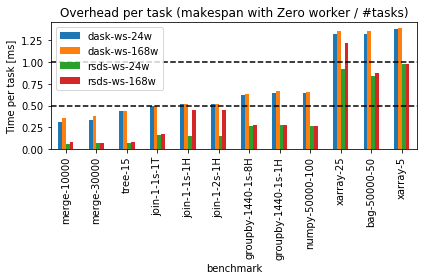

In [39]:
import itertools 
def get(df, runtime, scheduler, nodes):
    return df[(df.scheduler == scheduler) & (df.runtime == runtime) & (df.nodes == nodes)]

def comprel(df, runtime, scheduler, nodes):
    #baseline = get("rsds", "random", nodes).groupby("function")["time"].mean()
    baseline = get(df, "dask", "ws", nodes).groupby("function")["time"].mean()
    print(df.nodes.unique())
    vals = get(df, runtime, scheduler, nodes).groupby("function")["time"].mean()
    r = baseline / vals
    return r.sort_values()

confs = [
    ("rsds", "ws"),
]

frame = pd.DataFrame(df[~df.benchmark.isin(["merge-15000", "merge-20000", "merge-25000"])])
frame["ttime"] = frame.apply(lambda r: r.time / SZS[r.benchmark] * 1000, axis=1)

for r, s in confs:
    new_df = pd.DataFrame()

    for runtime, nodes in itertools.product(["dask", "rsds"], [1, 7]):
        data = get(frame, runtime, "ws", nodes).groupby("benchmark")["ttime"].mean()
        new_df[f"{runtime}-ws-{nodes * 24}w"] = data
        
    print(new_df)
    print(new_df.min(), new_df.max())
    new_df.sort_values("dask-ws-24w").plot.bar()    
    #plt.figure(figsize=(8, 5))
    plt.title("Overhead per task (makespan with Zero worker / #tasks)")

    plt.xlabel("benchmark")        
    plt.ylabel("Time per task [ms]")        
    plt.axhline(y=1.0, color='black', linestyle='--')
    plt.axhline(y=0.5, color='black', linestyle='--')
    #plt.autoscale()
    plt.tight_layout()
    plt.savefig("tt-all.png", tight_layout=True)
    plt.show()

[1, 'dask', 'ws', 'zw', '1n', '24p', '1t']
[7, 'rsds', 'ws', 'zw', '7n', '24p', '1t']
[1, 'rsds', 'ws', 'zw', '1n', '24p', '1t']
[7, 'dask', 'ws', 'zw', '7n', '24p', '1t']


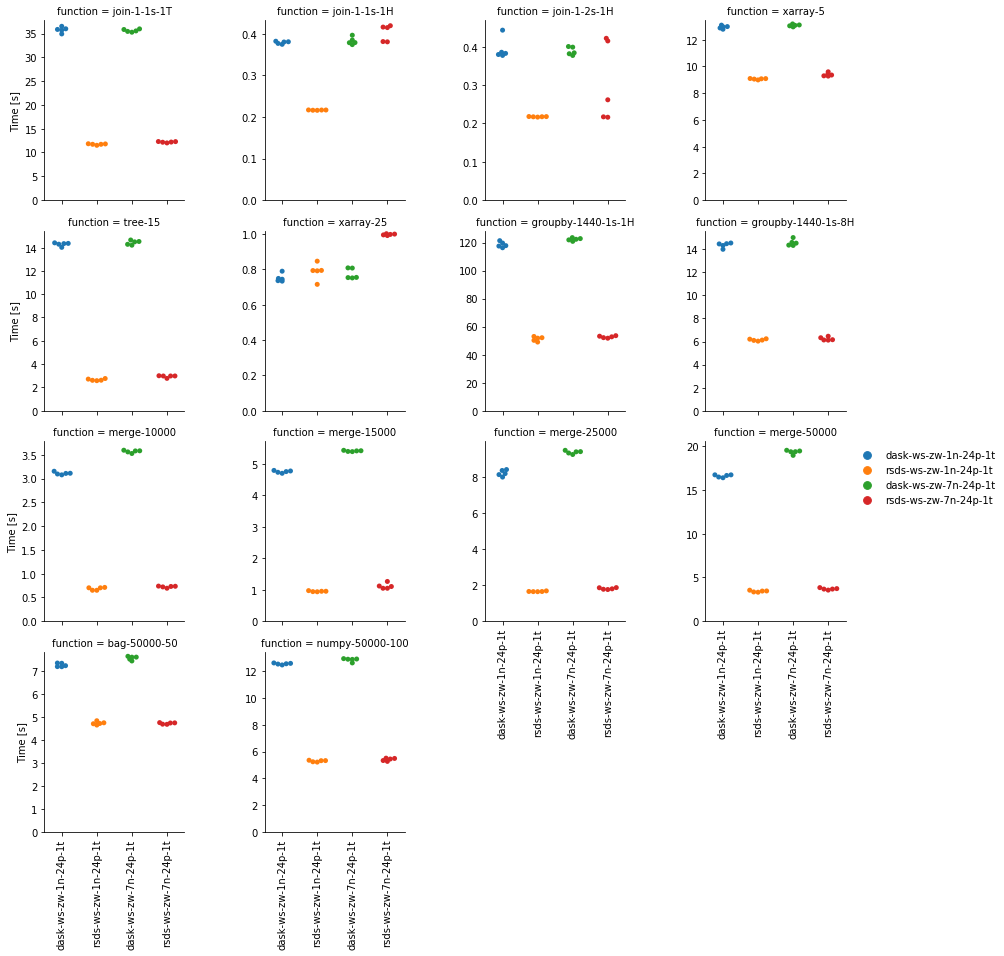

In [8]:
def create_plot(frame, plot_fn):
    def extract(fn):
        sortkey = []
        for item in fn.split("-"):
            try:
                num = float(item)
                sortkey.append(num)
            except:
                pass
        return tuple(sortkey)
    
    
    def cluster_key(name):        
        t = name.split("-")
        for x in t:
            if x and x[0].isdigit():
                break        
        key = [int(x[:-1])] + t
        print(key)
        return key
    
    clusters = sorted(set(frame["cluster"]), key=cluster_key)
    functions = sorted(frame["function"].unique(), key=extract)

    def plot(data, **kwargs):
        plot_fn(data, clusters, **kwargs)

    g = sns.FacetGrid(frame, col="function", col_wrap=4, col_order=functions, sharey=False)
    g = g.map_dataframe(plot)
    g = g.add_legend()
    g.set_ylabels("Time [s]")
    g.set(ylim=(0, None))
    g.set_xticklabels(rotation=90)
    return g

def plot_scatter(data, clusters, **kwargs):
    y = data["time"]
    sns.swarmplot(x=data["cluster"], y=y, hue=data["cluster"], order=clusters, hue_order=clusters)


#selection = df[df.function.isin(["xarray-5", "tree-15", "pandas_groupby-90-1s-8H", "numpy-50000-10"])]
selection = df2
create_plot(selection, plot_scatter)
#plt.savefig('ws_sample.png', bbox_inches='tight')